In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm

import rasterio
from scipy.ndimage import gaussian_filter

## Helper functions used throughout

In [2]:
def get_cumulative_area(df, total_area, minimum = 0):
    df = df[df.diameter > minimum]
    # Sort the dataframe by diameter in descending order
    df_sorted = df.sort_values(by=['diameter'], ascending=False)

    # Calculate the cumulative area
    df_sorted['cumulative_area'] = df_sorted['boulder_area'].cumsum()

    # Extract the diameters and cumulative areas into separate arrays
    diameters = df_sorted['diameter'].to_numpy()
    cumulative_areas = df_sorted['cumulative_area'].to_numpy()
    cumulative_areas /= total_area
    
    return diameters, cumulative_areas

def rock_abundance_function(D, k, q):
    return k * np.exp(-q * D)

# Figure 1 (Boulder Maps & BoulderNet Rock Abundance vs Diameter)

Figures 1 a-c were made with QGIS. 

(a) uses APOLLO17_ORTHOMOSAIC_50CM.TIFF as background and BoulderNetBoulders.shp

(b) uses DivinerRockAbundanceMap.tif

(c) uses BoulderNetRockAbundanceMap.tif

# Figure 2 (verall Rock Abundance Model Fit)

In [700]:
bouldersGDF= pd.read_csv("Data/BouldersWithTileID.csv")

NUM_TILES = 864
total_area = NUM_TILES * bouldersGDF.tile_area[1]

bouldersGDF = bouldersGDF[['boulder_id', 'scores', 'boulder_area']]
bouldersGDF['diameter'] = 2 * np.sqrt(bouldersGDF['boulder_area'] / np.pi)

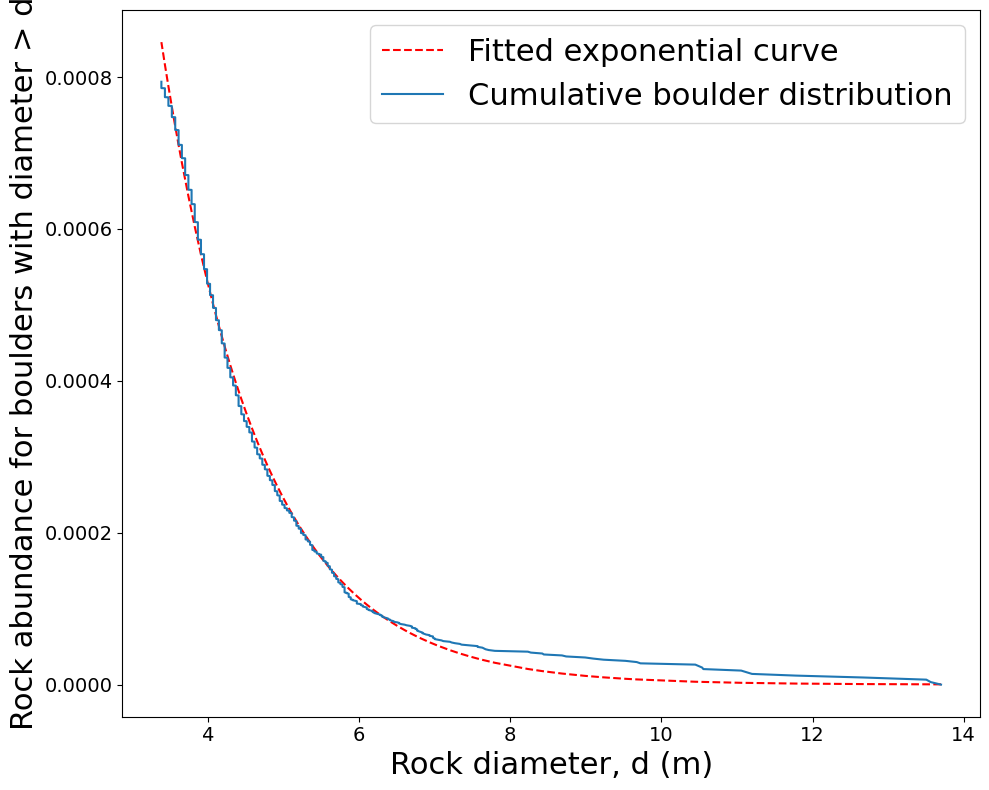

k: 0.011338255709450889
q: 0.7666917679776474
0.005267156750785063


In [702]:
diameterVals, arealFractionVals = get_cumulative_area(bouldersGDF, total_area=total_area, minimum=3.385)

params, pcov = curve_fit(lambda D,k,q:  rock_abundance_function(D, k, q),  diameterVals,  arealFractionVals,  p0=(0.01, 1))
k = params[0]
q = params[1]

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(diameterVals, rock_abundance_function(diameterVals, k, q), 'red', linestyle="--", label="Fitted exponential curve")
ax.plot(diameterVals, arealFractionVals, label="Cumulative boulder distribution")
ax.set_xlabel("Rock diameter, d (m)", fontsize=22)
ax.set_ylabel("Rock abundance for boulders with diameter > d", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=14)
legend = ax.legend(prop={'size': 22})


plt.tight_layout()

plt.show()

print(f'k: {k}')
print(f'q: {q}')
print(rock_abundance_function(1, k, q)) 

# Figure 3 (Smoothing Effect)

In [196]:
boulderNet_map_ra = "Data/BoulderNetRockAbundanceMap.tif"
diviner_map_ra = "Data/DivinerRockAbundanceMap.tif"

ds = rasterio.open(boulderNet_map_ra)
boulderNetRA = ds.read(1)
ds = rasterio.open(diviner_map_ra)
divinerRA = ds.read(1)
ds = None

Blurring the image

In [197]:
sigmas = [1.69, 0.78]

with rasterio.open(boulderNet_map_ra) as src:
    image_data = src.read(1)  
    blurred_image = gaussian_filter(image_data, sigma = sigmas)

In [129]:
with rasterio.open(
    "BlurredBoulderNetRAMap.tif",
    'w',
    width=src.width,
    height=src.height,
    count=1,  # Number of bands
    dtype=rasterio.float32,
    crs=src.crs, 
    transform=src.transform, 
) as dst:
    dst.write(blurred_image, 1)

In [198]:
blurredBoulderNet_map_ra = "BlurredBoulderNetRAMap.tif"
ds = rasterio.open(blurredBoulderNet_map_ra)
blurredBoulderNetRA = ds.read(1)
ds = None

No Smoothing Graph (Figure 3c)

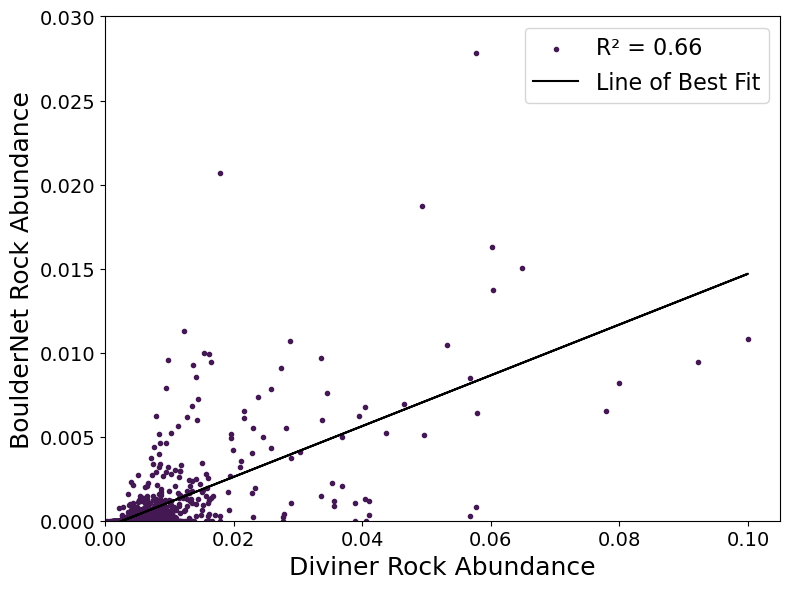

In [199]:
diviner_ra_vals = divinerRA.flatten()  
boulderNet_ra_vals = boulderNetRA.flatten()

plt.figure(figsize=(8, 6))  

r_squared = np.corrcoef(diviner_ra_vals, boulderNet_ra_vals)[0][1]
plt.scatter(diviner_ra_vals, boulderNet_ra_vals, label=f"R² = {r_squared:.2f}", marker='.', color="#431853")
a, b = np.polyfit(diviner_ra_vals, boulderNet_ra_vals, 1)
plt.plot(diviner_ra_vals, a * diviner_ra_vals + b, color="black", label='Line of Best Fit')

plt.xlabel("Diviner Rock Abundance", size=18)
plt.ylabel("BoulderNet Rock Abundance", size=18)

plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0, ymax=0.03)

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.legend(fontsize=16)
plt.tight_layout() 
plt.show()

Smoothing Graph (Figure 3d)

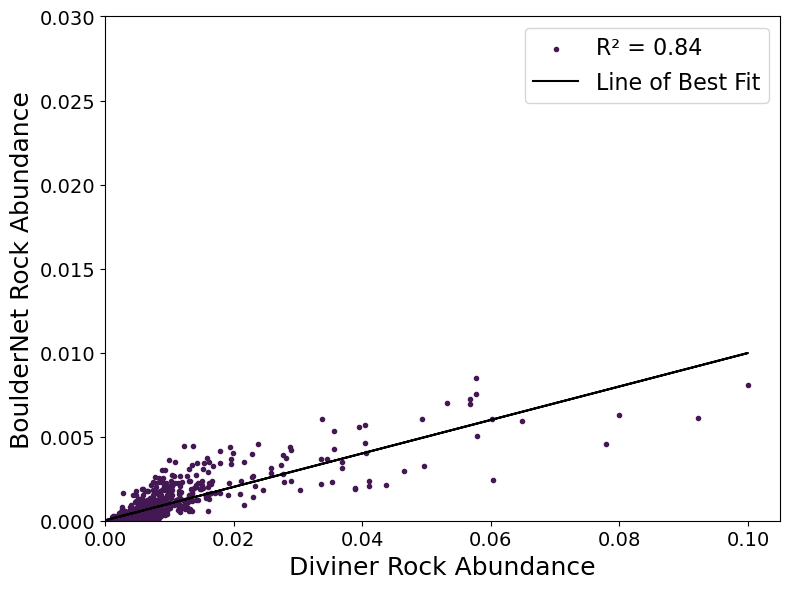

In [200]:
diviner_ra_vals = divinerRA.flatten() 
boulderNet_ra_vals = blurredBoulderNetRA.flatten()

plt.figure(figsize=(8, 6)) 

r_squared = np.corrcoef(diviner_ra_vals, boulderNet_ra_vals)[0][1]
plt.scatter(diviner_ra_vals, boulderNet_ra_vals, label=f"R² = {r_squared:.2f}", marker='.', color="#431853")
a, b = np.polyfit(diviner_ra_vals, boulderNet_ra_vals, 1)
plt.plot(diviner_ra_vals, a * diviner_ra_vals + b, color="black", label='Line of Best Fit')

plt.xlabel("Diviner Rock Abundance", size=18)
plt.ylabel("BoulderNet Rock Abundance", size=18)

plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0, ymax=0.03)

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.legend(fontsize=16)
plt.tight_layout() 
plt.show()

# Figure 4 (Diviner BoulderNet Comparison)

In [10]:
bouldersGDF= pd.read_csv("Data/BouldersWithTileID.csv")
bouldersGDF['diameter'] = 2 *np.sqrt(bouldersGDF['boulder_area'] / np.pi)
tilesDf = pd.read_csv("Data/TileDF.csv").rename(columns={'DivinerRAmean': 'DivinerRA'})

In [ ]:
def get_tile_index(grid_height, x, y):
    return x *grid_height + y + 1

divinerRAs = []
boulderNetRAs = []
corrBoulderNetRAs = []
k_vals = []
q_vals = []
mean_diameters = []
num_boulders = []
tile_area = bouldersGDF.tile_area[0]
center_tile_indices = []
perc_errs = []

verbose = False # Set to true to have fit for each sliding window comparsion graphed
x_limit = 32
y_limit = 27
for xIndex in range(1, x_limit - 1):
    for yIndex in range(1, y_limit -1):
        potentialTileCoords = [(xIndex - 1, yIndex - 1),(xIndex - 0, yIndex - 1),(xIndex + 1, yIndex - 1),
                                (xIndex - 1, yIndex - 0),(xIndex - 0, yIndex - 0),(xIndex + 1, yIndex - 0),
                                (xIndex - 1, yIndex + 1),(xIndex - 0, yIndex + 1),(xIndex + 1, yIndex + 1)]
        
        potentialTileIndicies = [get_tile_index(y_limit, pos[0], pos[1]) for pos in potentialTileCoords]
        tileData = tilesDf[tilesDf["id"].isin(potentialTileIndicies)]
        avgArealFrac = tileData.ArealFrac.mean()
        
        if (len(tileData) == 0):
            continue
        
        divinerRA = tileData['DivinerRA'].mean()
        boulderNetRA = tileData['ArealFrac'].mean()

        
        boulders = bouldersGDF[bouldersGDF["id"].isin(potentialTileIndicies)] 
        if (len(boulders) < 100):
            continue

        divinerRAs.append(divinerRA)
        boulderNetRAs.append(boulderNetRA)  
        diameterVals, arealFractionVals = get_cumulative_area(boulders, total_area=tile_area*9, minimum=3.38) 

        params, pcov = curve_fit(lambda D,k,q:  rock_abundance_function(D, k, q),  diameterVals,  arealFractionVals,  p0=(0.01, 1))
        k = params[0]
        q = params[1]
        correct_rock_abundance = rock_abundance_function(1, k, q) 
        corrBoulderNetRAs.append(correct_rock_abundance)
        k_vals.append(k)
        q_vals.append(q)

        mean_diameter = np.median(boulders['diameter'])
        mean_diameters.append(mean_diameter)

        num_boulders.append(len(boulders))
        center_tile_indices.append(potentialTileIndicies[4])
        predicted_arealFractionVals = rock_abundance_function(diameterVals, k, q)
        residuals = arealFractionVals - predicted_arealFractionVals
        rmse = np.sqrt(np.mean(residuals**2))
        perc_err = np.mean(np.abs(arealFractionVals - predicted_arealFractionVals) / arealFractionVals)
        perc_errs.append(perc_err)

        if verbose:
            plt.plot(diameterVals, rock_abundance_function(diameterVals, k, q), 'red', linestyle="--", label="Fitted Exponential Curve")
            plt.plot(diameterVals, arealFractionVals, label="Cumulative Boulder Distribution")
            plt.xlabel("Diameter (meters, D)", fontsize=13)
            plt.ylabel("Rock Abundance for Boulders with Diameter > D", fontsize=13)
            plt.title("Rock Abundance Distribution of BoulderNet Detected Boulders", fontsize=16, color="white")
            plt.legend()
            plt.show()

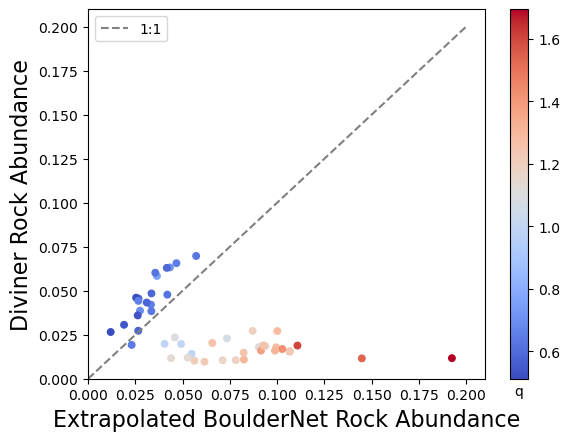

In [26]:
diviner_ra_vals = np.asarray(divinerRAs) 
boulderNet_ra_vals = np.asarray(corrBoulderNetRAs)

plt.scatter(boulderNet_ra_vals, diviner_ra_vals, marker='o', s=22, c=q_vals, cmap='coolwarm') #"#431853")

plt.plot([0, 0.2], [0, 0.2], c = 'gray', label = "1:1", linestyle="--")

plt.xlabel("Extrapolated BoulderNet Rock Abundance", fontsize=16)
plt.ylabel("Diviner Rock Abundance", fontsize=16)
plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0)
plt.legend()
cbar = plt.colorbar()
cbar.ax.set_xlabel('q')
plt.show() 

# Figure 5 (Diviner Threshold Analysis)

In [35]:
bouldersGDF= pd.read_csv("Data/BouldersWithTileID.csv")
bouldersGDF['diameter'] = 2 *np.sqrt(bouldersGDF['boulder_area'] / np.pi)
tilesDf = pd.read_csv("Data/TileDF.csv").rename(columns={'DivinerRAmean': 'DivinerRA'})

In [36]:
def get_tile_index(grid_height, x, y):
    return x *grid_height + y + 1

divinerRAs = []
boulderNetRAs = []
corrBoulderNetRAs = []
k_vals = []
q_vals = []
mean_diameters = []
num_boulders = []
tile_area = bouldersGDF.tile_area[0]

evalThreshDict = {}

evalThreshes = np.arange(0, 3.4 + 0.05, 0.05)

for evalThresh in evalThreshes:
    evalThreshDict[evalThresh] = []

x_limit = 32
y_limit = 27
for xIndex in range(1, x_limit - 1):
    for yIndex in range(1, y_limit -1):
        potentialTileIndexs = [(xIndex - 1, yIndex - 1),(xIndex - 1, yIndex - 0),(xIndex - 1, yIndex + 1),
                                (xIndex - 0, yIndex - 1),(xIndex - 0, yIndex - 0),(xIndex - 0, yIndex + 1),
                                (xIndex + 1, yIndex - 1),(xIndex + 1, yIndex - 0),(xIndex + 1, yIndex + 1)]
        
        potentialTileIndicies = [get_tile_index(x_limit, pos[0], pos[1]) for pos in potentialTileIndexs]
        actualTiles = tilesDf[tilesDf["id"].isin(potentialTileIndicies)]
        avgArealFrac = actualTiles.ArealFrac.mean()

        if (len(actualTiles) == 0):
            continue
        
        divinerRA = actualTiles['DivinerRA'].mean()
        boulderNetRA = actualTiles['ArealFrac'].mean()
        
        boulders = bouldersGDF[bouldersGDF["id"].isin(potentialTileIndicies)]
        if (len(boulders) < 100):
            continue

        diameterVals, arealFractionVals = get_cumulative_area(boulders, total_area=tile_area*9, minimum=3.38) 

        params, pcov = curve_fit(lambda D,k,q:  rock_abundance_function(D, k, q),  diameterVals,  arealFractionVals,  p0=(0.01, 1))
        k = params[0]
        q = params[1]
        
        k_vals.append(k)
        q_vals.append(q)

        divinerRAs.append(divinerRA)
        boulderNetRAs.append(boulderNetRA)  
        
        mean_diameter = np.median(boulders['diameter'])
        mean_diameters.append(mean_diameter)

        num_boulders.append(len(boulders))

        
        for evalThresh in evalThreshDict:
            evalThreshDict[evalThresh].append(rock_abundance_function(evalThresh, k, q))


In [37]:
thresholds = sorted(evalThreshDict.keys(),reverse=True)
correctThresholds = []
for i in range(len(divinerRAs)):
    errors = []
    for evalThresh in thresholds:
        uncorrRockAbundance = evalThreshDict[evalThresh][i]
        errors.append(np.abs(divinerRAs[i] - uncorrRockAbundance))
    threshold = thresholds[np.argmin(errors)]
    correctThresholds.append(threshold)

2.847516388334012 -1.0379797940559055 -1.4735042631522441


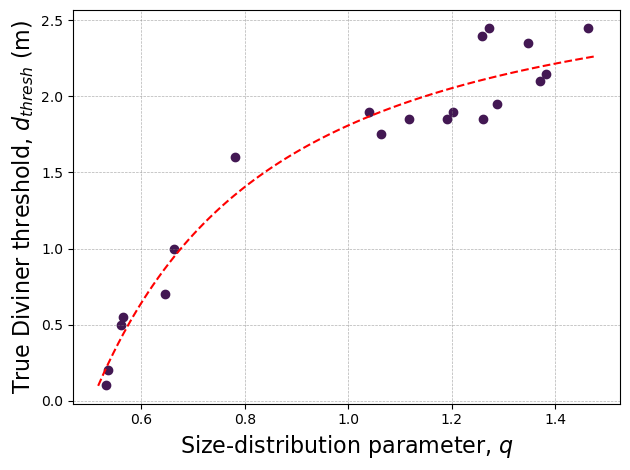

In [73]:
def model_func(x, a, b, c):
    return a + b*x**c

params, covariance = curve_fit(lambda x,a,b,c:  model_func(x, a, b, c), q_vals, correctThresholds, p0=(1, -1, -1))

a, b, c = params

x_fit = np.linspace(min(q_vals)*0.97, max(q_vals)*1.01, 100)
y_fit = model_func(x_fit, a, b, c)

plt.scatter(q_vals, correctThresholds, color = "#431853") 
plt.plot(x_fit, y_fit, color='red', linestyle='--')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
plt.xlabel("Size-distribution parameter, $q$", size = 16)
plt.ylabel("True Diviner threshold, $d_{thresh}$ (m)", size = 16)
plt.tight_layout()
plt.show()